# Experimental Self-Attention with ScRRAMBLe
- As the search for interesting architectures mappable on ScRRAMBLe framework continues, we explore a simplified self-attention scheme that can be used in ScRRAMBLe framework.
- The idea is to implement an architecture similar to capsule networks where the lower-level capsules have to agree with higher-level capsules about presence of specific structure of inputs.
- With self-attention the hope is to do away with iterative dynamical routing approach in favor of self-attention-based approach.

In [2]:
import jax
import jax.numpy as jnp
import flax
from flax import nnx
from flax.nnx.nn import initializers
from collections import defaultdict
from functools import partial
from typing import Callable
from utils import clipping_ste, intercore_connectivity
from models import ScRRAMBLeLayer

import matplotlib.pyplot as plt
import seaborn as sns

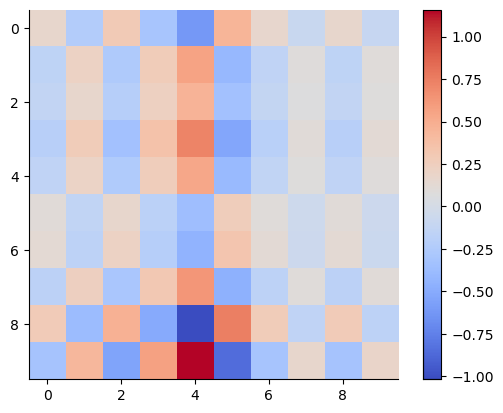

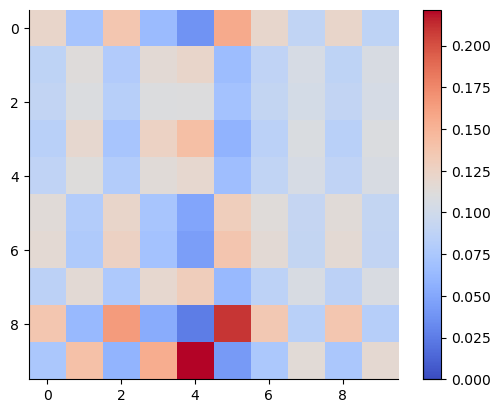

In [2]:
## some preliminary tests
rngs = nnx.Rngs(params=0, activation=1, permute=3)
k = jax.random.normal(rngs.params(), (10, ))
q = jax.random.normal(rngs.activation(), (10, ))
s = jnp.einsum('i,j->ij', k, q)/jnp.sqrt(10)
wa = nnx.softmax(s, axis=0)

plt.figure()
im = plt.imshow(s, cmap='coolwarm')
plt.colorbar(im)
sns.despine()

plt.figure()
im = plt.imshow(wa, cmap='coolwarm', vmin=0)
plt.colorbar(im)

sns.despine()


In [4]:
print(wa[0, :])
print(sum(wa[:, 0]))

[0.12163003 0.07259364 0.13670275 0.06485971 0.03759335 0.15594871
 0.12067766 0.08915466 0.12171231 0.08759107]
1.0


## Single ScRRAMBLe layer

In [28]:
class ScRRAMBLeCapsule(nnx.Module):
    """
    Experimental ScRRAMBLe module that can be a capsule.
    - Initializes cores with trainable parameters which serve as the weights for KV-parameters.
    - This module takes in an input and computes keys and values.
    """

    def __init__(
            self,
            input_vector_size: int,
            num_cores: int,
            avg_slot_connectivity: int, 
            slots_per_core: int,
            slot_length: int,
            activation: Callable,
            rngs: nnx.Rngs,
            core_length: int = 256,
            threshold: float = 0.0,
            noise_sd: float = 0.05
        ):

        self.input_vector_size = input_vector_size
        self.num_cores = num_cores
        self.avg_slot_connectivity = avg_slot_connectivity
        self.slots_per_core = slots_per_core
        self.slot_length = slot_length
        self.activation = activation
        self.rngs = rngs
        self.core_length = core_length
        self.threshold = threshold
        self.noise_sd = noise_sd

        self.activation = partial(self.activation, threshold=self.threshold, noise_sd=self.noise_sd, key=rngs.activation())

        # define weights for input cores
        initializer = initializers.glorot_normal()
        self.Wi = nnx.Param(initializer(self.rngs.params(), (self.num_cores, self.slots_per_core, self.slots_per_core, self.slot_length, self.slot_length)))

        # define a padding width for input vector
        self.pad_width = self.core_length - (self.input_vector_size % self.core_length) if self.input_vector_size % self.core_length != 0 else 0

        self.input_eff_cores = (self.input_vector_size + self.pad_width) // self.core_length
        print(f"Effective input cores: {self.input_eff_cores}, Padding width: {self.pad_width}")

        # define connectivity matrix between input vector and input cores: we can trat input as if it came from a layer of cores
        Ci = intercore_connectivity(
            input_cores=self.input_eff_cores,
            output_cores=self.num_cores,
            slots_per_core=self.slots_per_core,
            avg_slot_connectivity=self.avg_slot_connectivity,
            key=self.rngs.params()
        )

        self.Ci = nnx.Variable(Ci)


    def __call__(self, x):

        x = jnp.pad(x, (0, self.pad_width), constant_values=0)
        print(f"Padded input shape: {x.shape}, pad size: {self.pad_width}")

        # reshape the input
        x = x.reshape(self.input_eff_cores, self.slots_per_core, self.slot_length)

        # reconstruct the scrambled input
        x = jnp.einsum('ijkl,ijm->klm', self.Ci.value, x)

        # Feed this into the first set of cores
        y1 = jnp.einsum('ijklm,ikm->ijl', self.Wi.value, x)

        # apply the non-linearity
        y1 = self.activation(y1)

        return y1
        



In [ ]:
# testing
rngs = nnx.Rngs(params=0, activation=1, permute=3)
x_test = jax.random.normal(key=rngs.params(), shape=(15, 1000))
test_cap = ScRRAMBLeCapsule(
    input_vector_size=1000,
    num_cores=10,
    avg_slot_connectivity=5,
    slots_per_core=4,
    slot_length=64,
    activation=clipping_ste,
    rngs=rngs,
)

y_test = nnx.vmap(test_cap, in_axes=0)(x_test)
print(f"Output shape: {y_test.shape}")
print(f"Output: {y_test}")

Effective input cores: 4, Padding width: 24
Padded input shape: (1024,), pad size: 24
Output shape: (15, 10, 4, 64)
Output: [[[[1. 1. 0. ... 1. 1. 0.]
   [1. 1. 1. ... 0. 0. 0.]
   [0. 0. 1. ... 0. 1. 0.]
   [0. 0. 1. ... 0. 1. 1.]]

  [[1. 1. 1. ... 0. 0. 0.]
   [1. 1. 1. ... 1. 1. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 1. 0. ... 1. 0. 1.]]

  [[1. 0. 0. ... 0. 0. 0.]
   [0. 1. 0. ... 0. 0. 1.]
   [0. 0. 1. ... 1. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 1. 0. ... 0. 0. 1.]
   [1. 1. 0. ... 0. 1. 1.]
   [1. 0. 0. ... 0. 0. 1.]
   [1. 0. 0. ... 1. 0. 1.]]

  [[0. 1. 1. ... 0. 0. 1.]
   [1. 1. 1. ... 0. 1. 1.]
   [0. 0. 0. ... 0. 0. 1.]
   [1. 1. 0. ... 0. 1. 1.]]

  [[0. 1. 0. ... 1. 1. 0.]
   [1. 1. 0. ... 0. 1. 0.]
   [0. 1. 1. ... 1. 0. 0.]
   [0. 0. 1. ... 1. 1. 1.]]]


 [[[1. 1. 1. ... 1. 1. 0.]
   [1. 1. 1. ... 0. 1. 0.]
   [0. 0. 0. ... 0. 0. 1.]
   [0. 1. 1. ... 0. 1. 0.]]

  [[1. 1. 1. ... 0. 0. 0.]
   [1. 0. 1. ... 0. 0. 0.]
   [1. 1. 0. ... 1. 0. 0.]
   [0. 1. 1. ...

## Defining capsules
- Keys and values reside in primary capsules.
- Queries reside in the parent capsules.